# Predicting Customer Attrition for Beta Bank
## Overview:
This project addresses the critical issue of customer attrition at Beta Bank, where existing clients are gradually leaving, costing the bank significantly more in new customer acquisition than retaining current customers. The primary objective is to develop a predictive model that identifies customers likely to leave the bank, thereby enabling preemptive retention strategies. The model will be evaluated based on its F1 score, with a minimum target of 0.59, and its performance will also be assessed using the AUC-ROC metric to provide a comprehensive understanding of its predictive capability.
## Project Setup
**Data Preparation:**

(1) Load and clean the dataset, ensuring correct handling of data types and missing values.

(2) Process categorical features through encoding techniques and scale numerical features appropriately.

**Exploratory Data Analysis:**

(1) Investigate the distribution of features and identify any anomalies or outliers.

(2) Examine class distribution to understand the extent of imbalance between customers who stayed versus those who left.

**Baseline Model Training:**

(1) Develop an initial model without accounting for class imbalance to establish a performance baseline.

(2) Analyze the model’s performance, particularly focusing on the F1 score and AUC-ROC metrics.

**Handling Class Imbalance:**

(1) Implement at least two techniques to address the imbalance.

(2) Tune model parameters using cross-validation on the training set to determine the best configuration.

**Model Evaluation and Testing:**

(1) Compare the performance of different models trained on both training and validation sets.

(2) Select the best-performing model based on the F1 score and corroborate its reliability using the AUC-ROC metric.

(3) Perform final testing on the held-out test set to validate the model’s predictive power.

## Imports and Load Data

In [1]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle

In [2]:
# Load
data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
# Duplicates
data.duplicated().sum()

0

In [4]:
# Missing Values
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
# adding median to Tenure and changing to int
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data['Tenure'] = data['Tenure'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
# Gender Female = 0 Male = 1
data['Gender'] = pd.get_dummies(data['Gender'], drop_first=True)

In [7]:
# Geography France = 0 Germany = 1 Spain = 2
encoder = OrdinalEncoder()
data['Geography'] = encoder.fit_transform(data[['Geography']])
data['Geography'].value_counts()

0.0    5014
1.0    2509
2.0    2477
Name: Geography, dtype: int64

### Summary:
The dataset contains 10,000 customer records with 14 attributes. Key numerical features include CreditScore, Age, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, and Tenure (imputed with its median and converted to integer). Categorical variables have been encoded: Gender is binary (female = 0, male = 1), and Geography is ordinally encoded with France as 0, Germany as 1, and Spain as 2. The target variable, Exited, indicates customer churn, setting the foundation for predictive modeling.

## Class Balance

<AxesSubplot:ylabel='Exited'>

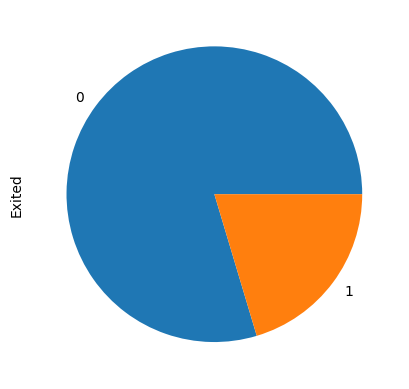

In [8]:
# Plot Balance Stayed = 0 Exit = 1
data['Exited'].value_counts(normalize=True).plot(kind='pie')

In [9]:
print(data['Exited'].value_counts(normalize=True))

0    0.7963
1    0.2037
Name: Exited, dtype: float64


### Summary:
The target variable exhibits a clear class imbalance, with about 79.6% of customers staying (Exited = 0) and roughly 20.4% exiting (Exited = 1). This distribution, visualized with a pie chart, indicates that the majority class significantly outweighs the minority class, which is an important factor to address in modeling to ensure effective detection of the exiting customers.

## Train Test Split

In [10]:
# Features/Target
features = data.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
target = data['Exited']

# 80% Train 20% Test
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

# 20% Test 20% Val 60% Train
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_val.shape)
print(target_val.shape)
print(features_test.shape)
print(target_test.shape)

## Thank you! It was actually more difficult to keep track of val so I will make sure to use valid in the future

(6000, 10)
(6000,)
(2000, 10)
(2000,)
(2000, 10)
(2000,)


In [11]:
# Scale
scaler = StandardScaler()
numeric = ['CreditScore', 'Age','Tenure','Balance','NumOfProducts','EstimatedSalary','Geography','Gender','HasCrCard','IsActiveMember']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_val[numeric] = scaler.transform(features_val[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train[numeric]

/tmp/ipykernel_50/3837678329.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[numeric] = scaler.transform(features_test[numeric])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography,Gender,HasCrCard,IsActiveMember
492,-0.134048,-0.078068,-0.369113,0.076163,0.816929,0.331571,-0.905741,-1.103311,-1.550255,0.968496
6655,-1.010798,0.494555,-0.007415,0.136391,-0.896909,-0.727858,-0.905741,0.906363,0.645055,0.968496
4287,0.639554,1.353490,-1.454209,0.358435,-0.896909,-0.477006,0.301109,0.906363,0.645055,0.968496
42,-0.990168,2.116987,-1.092511,0.651725,-0.896909,-0.100232,-0.905741,-1.103311,0.645055,0.968496
8178,0.567351,0.685430,0.715982,0.813110,0.816929,0.801922,-0.905741,-1.103311,0.645055,0.968496
...,...,...,...,...,...,...,...,...,...,...
8819,-0.618839,-0.268942,1.801078,0.744283,-0.896909,0.803658,0.301109,0.906363,-1.550255,0.968496
1537,1.743227,-1.032439,1.077681,-1.232442,-0.896909,-1.098797,-0.905741,-1.103311,0.645055,0.968496
1408,0.567351,-0.650691,1.439380,-1.232442,0.816929,-1.202257,-0.905741,0.906363,-1.550255,-1.032529
7661,-0.412545,0.494555,-1.092511,0.615524,-0.896909,-0.038931,0.301109,0.906363,0.645055,0.968496


In [12]:
features_val[numeric]

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography,Gender,HasCrCard,IsActiveMember
2358,0.175393,0.399118,-1.454209,1.385698,-0.896909,-1.466761,-0.905741,0.906363,-1.550255,0.968496
8463,-1.299609,0.971741,-1.092511,-1.232442,-0.896909,0.254415,1.507960,0.906363,0.645055,-1.032529
163,0.711757,-0.268942,-1.092511,-1.232442,0.816929,0.122863,1.507960,-1.103311,0.645055,0.968496
3074,-0.391916,0.494555,0.354284,0.672529,-0.896909,0.585847,0.301109,-1.103311,0.645055,-1.032529
5989,0.165078,1.353490,1.801078,0.536522,-0.896909,1.462457,-0.905741,-1.103311,-1.550255,-1.032529
...,...,...,...,...,...,...,...,...,...,...
207,-0.350657,-0.459816,-0.007415,0.933102,-0.896909,0.905307,-0.905741,0.906363,0.645055,0.968496
8746,0.082561,-0.459816,1.077681,0.476293,0.816929,1.432571,-0.905741,0.906363,-1.550255,0.968496
1809,-0.134048,1.067178,0.354284,0.618283,0.816929,-0.813904,-0.905741,-1.103311,0.645055,0.968496
5919,-0.072160,0.971741,1.077681,-1.232442,0.816929,1.080287,1.507960,0.906363,0.645055,-1.032529


In [13]:
features_test[numeric]

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography,Gender,HasCrCard,IsActiveMember
7867,-0.123733,0.685430,-0.730812,-1.232442,-0.896909,0.980212,1.507960,-1.103311,0.645055,0.968496
1402,1.083087,-0.937002,1.077681,0.858518,-0.896909,-0.390486,-0.905741,0.906363,0.645055,-1.032529
8606,1.598822,0.303681,-0.007415,-1.232442,0.816929,-0.435169,1.507960,0.906363,0.645055,0.968496
8885,0.165078,0.589993,-0.369113,0.412100,0.816929,1.017079,1.507960,0.906363,0.645055,0.968496
6494,0.484834,-1.032439,0.715982,-1.232442,0.816929,-1.343558,-0.905741,0.906363,0.645055,0.968496
...,...,...,...,...,...,...,...,...,...,...
2563,1.970151,-1.127876,-0.007415,-1.232442,0.816929,-0.564021,-0.905741,-1.103311,0.645055,0.968496
1167,-1.072686,-0.364379,1.801078,-1.232442,-0.896909,-1.193686,-0.905741,-1.103311,0.645055,0.968496
1009,-0.020586,3.071359,-1.815908,-1.232442,-0.896909,1.312849,1.507960,0.906363,0.645055,0.968496
1002,0.753016,0.017370,-1.454209,-0.415981,0.816929,1.463205,0.301109,0.906363,0.645055,0.968496


### Summary:
The data was split into features and target, with features excluding non-predictive columns like RowNumber, CustomerId, and Surname, and the target defined as Exited. The dataset was divided into an 80/20 train-test split, and the training set was further split into 60% training and 20% validation, resulting in 6000 training samples, 2000 validation samples, and 2000 test samples. Next, a standard scaler was applied to all numeric features to ensure they are on a similar scale before training. This preprocessing setup prepares the data for model training and evaluation while maintaining consistency across the splits.

## Training Baseline Models

In [14]:
# Baseline Logistic Model
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predictions_val = model.predict(features_val)

print('Accuracy Score:', accuracy_score(target_val, predictions_val))
print('F1 Score:', f1_score(target_val, predictions_val))

probability_val = model.predict_proba(features_val)
probability_val = probability_val[:,1]
auc_roc = roc_auc_score(target_val, probability_val)

print('AUC-ROC Score:', auc_roc)

Accuracy Score: 0.8135
F1 Score: 0.2729044834307992
AUC-ROC Score: 0.7597290814615358


In [15]:
# Baseline Decision Tree Model
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_train, target_train)
predictions_val = model.predict(features_val)

print('Accuracy Score:', accuracy_score(target_val, predictions_val))
print('F1 Score:', f1_score(target_val, predictions_val))

probability_val = model.predict_proba(features_val)
probability_val = probability_val[:,1]
auc_roc = roc_auc_score(target_val, probability_val)

print('AUC-ROC Score:', auc_roc)

Accuracy Score: 0.8555
F1 Score: 0.5025817555938038
AUC-ROC Score: 0.8118448179120326


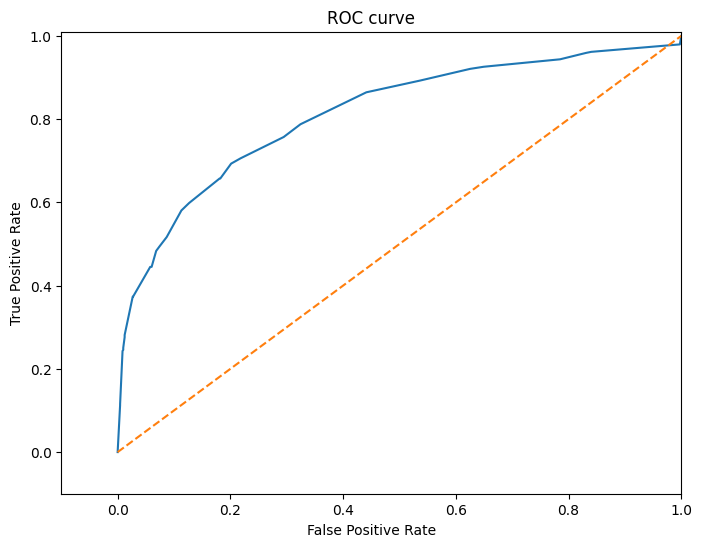

In [16]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(target_val, probability_val)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [17]:
# Baseline RandomForest
model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=6)
model.fit(features_train, target_train)
predictions_val = model.predict(features_val)

print('Accuracy Score:', accuracy_score(target_val, predictions_val))
print('F1 Score:', f1_score(target_val, predictions_val))

probability_val = model.predict_proba(features_val)
probability_val = probability_val[:,1]
auc_roc = roc_auc_score(target_val, probability_val)

print('AUC-ROC Score:', auc_roc)

Accuracy Score: 0.857
F1 Score: 0.4964788732394366
AUC-ROC Score: 0.8420728033964958


### Summary:
The baseline Logistic Regression model achieved an accuracy of 81.35%, but its F1 score was relatively low at 0.27, with an AUC-ROC of 0.76, indicating limited effectiveness in capturing the minority class. In contrast, the Decision Tree model improved overall performance with an accuracy of 85.55%, an F1 score of 0.50, and an AUC-ROC of 0.81, suggesting better balance between precision and recall. The Random Forest model delivered comparable accuracy (85.70%) and F1 score (0.50) while further improving the AUC-ROC to 0.84, making it the strongest performer among the three in terms of distinguishing between classes.

## Upsampling

In [18]:
# Upsample Function
def upsample(features, target, repeat):
    feature1 = features[target == 1]
    feature0 = features[target == 0]
    target1 = target[target == 1]
    target0 = target[target == 0]
    
    features_upsampled = pd.concat([feature0] + [feature1] * repeat)
    
    target_upsampled = pd.concat([target0] + [target1] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [19]:
# Upsample by 3
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

In [20]:
# LogisticRegression
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predictions_val = model.predict(features_val)

print('F1 Score', f1_score(target_val, predictions_val))
print('AUC-ROC Score', roc_auc_score(target_val, predictions_val))

F1 Score 0.4757894736842105
AUC-ROC Score 0.68552213492201


In [21]:
# DecisionTree
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_upsampled, target_upsampled)
predictions_val = model.predict(features_val)

print('F1 Score', f1_score(target_val, predictions_val))
print('AUC-ROC Score', roc_auc_score(target_val, predictions_val))

F1 Score 0.5592841163310962
AUC-ROC Score 0.7410728335974592


In [22]:
# RandomForest
model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=6)
model.fit(features_upsampled, target_upsampled)
predictions_val = model.predict(features_val)

print('F1 Score', f1_score(target_val, predictions_val))
print('AUC-ROC Score', roc_auc_score(target_val, predictions_val))

F1 Score 0.5768772348033372
AUC-ROC Score 0.7454479995040684


### Summary:
Upsampling the minority class by a factor of three improved F1 scores across models: Logistic Regression reached 0.476, Decision Tree 0.559, and Random Forest 0.577, while AUC-ROC scores were 0.686, 0.741, and 0.745 respectively. This indicates enhanced detection of the minority class, with Random Forest providing the best balance between precision, recall, and overall ranking performance.

## Downsampling

In [23]:
# Downsampling Function
def downsample(features,target,fraction):
    feature1 = features[target == 1]
    feature0 = features[target == 0]
    target1 = target[target == 1]
    target0 = target[target == 0]
    
    features_downsampled = pd.concat([feature0.sample(frac=fraction, random_state=12345)] + [feature1])
    
    target_downsampled = pd.concat([target0.sample(frac=fraction, random_state=12345)] + [target1])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [24]:
# Downsample by 10%
features_downsampled, target_downsampled = downsample(features_train, target_train, .1)

In [25]:
# LogisticRegression
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predictions_val = model.predict(features_val)

print('F1 Score', f1_score(target_val, predictions_val))
print('AUC-ROC Score', roc_auc_score(target_val, predictions_val))

F1 Score 0.39782016348773835
AUC-ROC Score 0.6314504886992762


In [26]:
# DecisionTree
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_downsampled, target_downsampled)
predictions_val = model.predict(features_val)

print('F1 Score', f1_score(target_val, predictions_val))
print('AUC-ROC Score', roc_auc_score(target_val, predictions_val))

F1 Score 0.42839352428393523
AUC-ROC Score 0.669232688887158


In [27]:
# RandomForest
model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=6)
model.fit(features_downsampled, target_downsampled)
predictions_val = model.predict(features_val)

print('F1 Score', f1_score(target_val, predictions_val))
print('AUC-ROC Score', roc_auc_score(target_val, predictions_val))

F1 Score 0.4400948991696323
AUC-ROC Score 0.6872896860530361


### Summary:
Downsampling the majority class to 10% of its original size resulted in a reduction of model performance. The Logistic Regression model achieved an F1 score of about 0.398 and an AUC-ROC of 0.631, while the Decision Tree and Random Forest models reached F1 scores of approximately 0.428 and 0.440, with AUC-ROC scores of 0.669 and 0.687, respectively. These metrics indicate that reducing the number of majority class samples can impair the models’ ability to effectively distinguish between classes, leading to lower performance compared to other resampling strategies.

## Final Model

In [28]:
model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=6)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)

print('Accuracy Score:', accuracy_score(target_test, predicted_test))
print('F1 Score:', f1_score(target_test, predicted_test))
print('AUC-ROC Score:', roc_auc_score(target_test, predicted_test))

Accuracy Score: 0.827
F1 Score: 0.6197802197802198
AUC-ROC Score: 0.7663201180339779


### Summary:
The final model is a RandomForestClassifier configured with 20 estimators and a maximum depth of 6, trained on the upsampled dataset to better address class imbalance. When evaluated on the test set, it achieved an accuracy of 82.7%, an F1 score of approximately 0.62, and an AUC-ROC of 0.77. These results indicate that the model not only meets but exceeds the project threshold for the F1 score (0.59), demonstrating a strong balance between precision and recall, while also maintaining robust overall classification performance.

## Conclusion:
In this analysis, we developed a predictive model to address customer churn for Beta Bank. The dataset, comprising 10,000 customer records with diverse numerical and categorical attributes, required careful preprocessing, including handling missing values and encoding categorical variables. Our initial evaluation revealed a significant class imbalance which highlighted the need for specialized techniques to improve minority class detection. Through a series of experiments with baseline models, we observed that traditional models struggled with the imbalanced data, prompting the use of resampling strategies. Upsampling the minority class by a factor of three notably improved the F1 scores across models, with the Random Forest classifier achieving the best performance, reaching an F1 score of approximately 0.62 and an AUC-ROC of 0.77. In contrast, downsampling the majority class led to poorer outcomes. Ultimately, the final Random Forest model not only met but exceeded our target performance threshold, providing a robust and balanced solution for predicting customer churn. These results offer the client a valuable tool for identifying at-risk customers and implementing targeted retention strategies, thereby improving overall customer management and reducing attrition costs.